In [1]:
import pickle
import json  # 存loss, acc
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
#################################################
import cv2
# import matplotlib.pyplot as plt
import math

import os
import multiprocessing as mp
from tqdm import tqdm
# import time
#################################################
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

In [59]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (32, 32))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f440edba518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f440eda2e10>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dat

In [ ]:
np.save(file="./data/resized_train_imgs.npy", arr=resized_train_imgs)
np.save(file="./data/resized_val_imgs.npy", arr=resized_val_imgs)
np.save(file="./data/resized_test_imgs.npy", arr=resized_test_imgs)
np.save(file="./data/train_label", arr=train_label)
np.save(file="./data/val_label", arr=val_label)
np.save(file="./data/test_label", arr=test_label)

In [30]:
resized_train_imgs = np.load(file="./data/resized_train_imgs.npy")
resized_val_imgs = np.load(file="./data/resized_val_imgs.npy")
resized_test_imgs = np.load(file="./data/resized_test_imgs.npy")
train_label = np.load(file="./data/train_label.npy")
val_label = np.load(file="./data/val_label.npy")
test_label = np.load(file="./data/test_label.npy")

In [31]:
def MoveColorChannel(image: np.ndarray) -> np.ndarray:
    return np.moveaxis(image, source=2, destination=0)  # reshape (H, W, C) to (C, H, W)

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(MoveColorChannel, tqdm(resized_train_imgs))
    resized_val_imgs = pool.map(MoveColorChannel, tqdm(resized_val_imgs))
    resized_test_imgs = pool.map(MoveColorChannel, tqdm(resized_test_imgs))


100%|██████████| 450/450 [00:00<00:00, 27973.63it/s]


In [32]:
# convert list to numpy.ndarray
resized_train_imgs = np.array(resized_train_imgs)
resized_val_imgs = np.array(resized_val_imgs)
resized_test_imgs = np.array(resized_test_imgs)
# list to numpy.ndarray
train_label = np.array(train_label)
val_label = np.array(val_label)
test_label = np.array(test_label)

In [33]:
# check the shape
print(resized_train_imgs.shape)
print(resized_val_imgs.shape)
print(resized_test_imgs.shape)
print()
print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

(63325, 3, 32, 32)
(450, 3, 32, 32)
(450, 3, 32, 32)

(63325,)
(450,)
(450,)


In [34]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = resized_train_imgs, train_label, \
                                                 resized_val_imgs, val_label, \
                                                 resized_test_imgs, test_label
# normalization
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)


# TensorDataset
resized_train_imgs = torch.FloatTensor(resized_train_imgs)
resized_val_imgs = torch.FloatTensor(resized_val_imgs)
resized_test_imgs = torch.FloatTensor(resized_test_imgs)
# resized_train_imgs = resized_train_imgs.permute(0, 3, 1, 2)
# resized_val_imgs = resized_val_imgs.permute(0, 3, 1, 2)
# resized_test_imgs = resized_test_imgs.permute(0, 3, 1, 2)

train_label = torch.IntTensor(train_label)
val_label = torch.IntTensor(val_label)
test_label = torch.IntTensor(test_label)

train_dataset = TensorDataset(resized_train_imgs, train_label)
val_dataset = TensorDataset(resized_val_imgs, val_label)
test_dataset = TensorDataset(resized_test_imgs, test_label)

BATCH_SIZE = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)

In [35]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.activ1 = nn.Sigmoid()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.activ2 = nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.activ3 = nn.Sigmoid()
        self.fc2 = nn.Linear(120, 84)
        self.activ4 = nn.Sigmoid()
        self.fc3 = nn.Linear(84, 50)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activ1(self.conv1(x))
        x = self.pool1(x)
        x = self.activ2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.activ3(self.fc1(x))
        x = self.activ4(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on {device}.")

Training on cuda.


In [37]:
model = LeNet5().to(device)
EPOCHS = 30
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def compute_accuracy(predictions, labels):
    # Compare predicted labels with ground truth labels
    # correct = (predictions == labels).sum().item()
    correct = torch.eq(predictions, labels).sum().item()
    # Calculate accuracy
    accuracy = correct / labels.size(0) * 100
    return accuracy


def train_loop(model, train_dataloader, val_dataloader, loss_fcn, optimizer, n_epochs):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(n_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_acc, val_acc = 0.0, 0.0

        # Training
        model.train()
        with tqdm(total=len(train_dataloader)) as pbar:
            for imgs, labels in train_dataloader:
                imgs, labels = imgs.to(device), labels.type(torch.LongTensor).to(device)
                # Forward pass
                outputs = model(imgs)  # Tensor
                preds = torch.argmax(outputs, dim=1)  # Tensor
                train_acc += compute_accuracy(preds, labels)
                # Compute loss
                loss = loss_fcn(outputs, labels)
                train_loss += loss
                # Backward propagation
                optimizer.zero_grad()
                loss.backward()
                # Gradient descent
                optimizer.step()
                # Update tqdm progress bar
                pbar.update(1)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        # Print training loss and training accuracy for every some epochs
        if epoch % 1 == 0:
            print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} %")

        # Validation
        model.eval()
        with torch.inference_mode():
            for X, y in val_dataloader:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                val_prob = model(X)
                val_pred = torch.argmax(val_prob, dim=1)

                val_loss += loss_fcn(val_prob, y)
                val_acc += compute_accuracy(val_pred, y)

            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_loop(model=model,
                                                                          train_dataloader=train_dataloader,
                                                                          val_dataloader=val_dataloader,
                                                                          loss_fcn=criterion,
                                                                          optimizer=optimizer,
                                                                          n_epochs=EPOCHS)


100%|██████████| 990/990 [00:14<00:00, 68.41it/s] 

Epoch: 1 | Train loss: 3.9068 | Train acc: 2.7497 %



100%|██████████| 990/990 [00:13<00:00, 71.02it/s] 

Epoch: 2 | Train loss: 3.8928 | Train acc: 4.5524 %



100%|██████████| 990/990 [00:09<00:00, 99.72it/s] 

Epoch: 3 | Train loss: 3.8839 | Train acc: 5.4261 %



100%|██████████| 990/990 [00:15<00:00, 64.14it/s] 

Epoch: 4 | Train loss: 3.8791 | Train acc: 6.1083 %



100%|██████████| 990/990 [00:15<00:00, 65.29it/s] 

Epoch: 5 | Train loss: 3.8754 | Train acc: 6.4969 %



100%|██████████| 990/990 [00:10<00:00, 90.90it/s] 

Epoch: 6 | Train loss: 3.8688 | Train acc: 7.2873 %



100%|██████████| 990/990 [00:09<00:00, 100.56it/s]

Epoch: 7 | Train loss: 3.8656 | Train acc: 7.6784 %



100%|██████████| 990/990 [00:13<00:00, 73.34it/s] 

Epoch: 8 | Train loss: 3.8629 | Train acc: 7.9969 %



100%|██████████| 990/990 [00:16<00:00, 61.34it/s] 

Epoch: 9 | Train loss: 3.8599 | Train acc: 8.3511 %



100%|██████████| 990/990 [00:16<00:00, 61.78it/s] 

Epoch: 10 | Train loss: 3.8576 | Train acc: 8.5430 %



100%|██████████| 990/990 [00:14<00:00, 68.78it/s] 

Epoch: 11 | Train loss: 3.8556 | Train acc: 8.8615 %



100%|██████████| 990/990 [00:18<00:00, 52.11it/s] 

Epoch: 12 | Train loss: 3.8517 | Train acc: 9.2260 %



100%|██████████| 990/990 [00:16<00:00, 59.35it/s] 

Epoch: 13 | Train loss: 3.8480 | Train acc: 9.6096 %



100%|██████████| 990/990 [00:12<00:00, 80.50it/s] 

Epoch: 14 | Train loss: 3.8458 | Train acc: 9.8504 %



100%|██████████| 990/990 [00:15<00:00, 63.09it/s] 

Epoch: 15 | Train loss: 3.8435 | Train acc: 10.1620 %



100%|██████████| 990/990 [00:18<00:00, 53.03it/s] 

Epoch: 16 | Train loss: 3.8409 | Train acc: 10.2926 %



100%|██████████| 990/990 [00:18<00:00, 52.59it/s] 

Epoch: 17 | Train loss: 3.8398 | Train acc: 10.5306 %



100%|██████████| 990/990 [00:13<00:00, 70.85it/s] 

Epoch: 18 | Train loss: 3.8383 | Train acc: 10.6563 %



100%|██████████| 990/990 [00:15<00:00, 65.68it/s] 

Epoch: 19 | Train loss: 3.8364 | Train acc: 10.8368 %



100%|██████████| 990/990 [00:21<00:00, 45.26it/s]

Epoch: 20 | Train loss: 3.8349 | Train acc: 10.9748 %



100%|██████████| 990/990 [00:15<00:00, 63.74it/s] 

Epoch: 21 | Train loss: 3.8333 | Train acc: 11.0830 %



100%|██████████| 990/990 [00:14<00:00, 66.90it/s] 

Epoch: 22 | Train loss: 3.8333 | Train acc: 11.1358 %



100%|██████████| 990/990 [00:15<00:00, 61.93it/s] 

Epoch: 23 | Train loss: 3.8301 | Train acc: 11.4981 %



100%|██████████| 990/990 [00:13<00:00, 71.79it/s] 

Epoch: 24 | Train loss: 3.8289 | Train acc: 11.5553 %



100%|██████████| 990/990 [00:16<00:00, 60.55it/s] 

Epoch: 25 | Train loss: 3.8287 | Train acc: 11.6301 %



100%|██████████| 990/990 [00:15<00:00, 64.24it/s] 

Epoch: 26 | Train loss: 3.8270 | Train acc: 11.7948 %



100%|██████████| 990/990 [00:15<00:00, 64.71it/s] 

Epoch: 27 | Train loss: 3.8271 | Train acc: 11.8160 %



100%|██████████| 990/990 [00:16<00:00, 60.19it/s]

Epoch: 28 | Train loss: 3.8246 | Train acc: 12.0610 %



100%|██████████| 990/990 [00:11<00:00, 85.64it/s] 

Epoch: 29 | Train loss: 3.8245 | Train acc: 12.0404 %



100%|██████████| 990/990 [00:16<00:00, 60.66it/s]

Epoch: 30 | Train loss: 3.8203 | Train acc: 12.5073 %


In [57]:
# save params
# weights = model.get_params()
# with open("pytorch_model.pkl","wb") as f:
# 	pickle.dump(weights, f)
torch.save(model.state_dict(), './model/pytorch_model.pt')

# train_loss_list = [x.cpu().item() for x in train_loss_list]
# val_loss_list = [x.cpu().item() for x in val_loss_list]
# train_acc_list = [x.cpu().item() for x in train_acc_list]
# val_acc_list = [x.cpu().item() for x in val_acc_list]
# train_loss_list = np.array(train_loss_list).tolist()
# val_loss_list = np.array(val_loss_list).tolist()
# train_acc_list = np.array(train_acc_list).tolist()
# val_acc_list = np.array(val_acc_list).tolist()
# save loss, accuracy
with open("./loss/pytorch_model_train_loss.txt", "w") as fp:
	json.dump(train_loss_list, fp)
with open("./loss/pytorch_model_val_loss.txt", "w") as fp:
	json.dump(val_loss_list, fp)
with open("./acc/pytorch_model_train_acc.txt", "w") as fp:
	json.dump(train_acc_list, fp)
with open("./acc/pytorch_model_val_acc.txt", "w") as fp:
	json.dump(val_acc_list, fp)


In [ ]:
# load params
# with open("pytorch_model.pkll", "rb") as f:
# 	model.set_params(params=pickle.load(f))
model = LeNet5()
model.load_state_dict(torch.load('./model/pytorch_model.pt')).to(device)

# load loss, accuracy
with open("./loss/pytorch_model_train_loss.txt", "r") as fp:
	train_loss_list = json.load(fp)
with open("./loss/pytorch_model_val_loss.txt", "r") as fp:
	val_loss_list = json.load(fp)
with open("./acc/pytorch_model_train_acc.txt", "r") as fp:
	train_acc_list = json.load(fp)
with open("./acc/pytorch_model_val_acc.txt", "r") as fp:
	val_acc_list = json.load(fp)

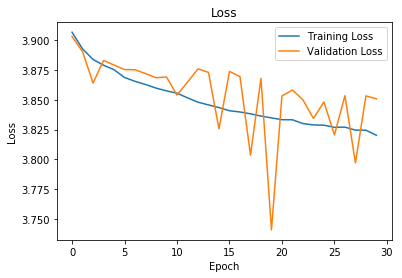

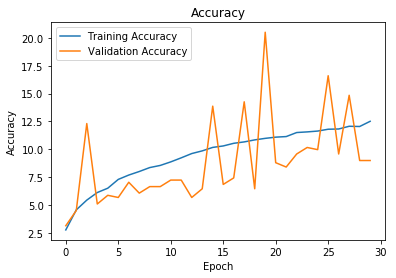

In [51]:
def draw_losses(train_losses=None, val_losses=None, test_losses=None):
    if train_losses!=None:
        plt.plot(np.arange(EPOCHS), train_losses, label='Training Loss')
    if val_losses!=None:
        plt.plot(np.arange(EPOCHS), val_losses, label='Validation Loss')
    if test_losses!=None:    
        plt.plot(np.arange(EPOCHS), test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./pic/pytorch_model_loss.png')
    plt.show()
    
def draw_accuracy(train_acc=None, val_acc=None, test_acc=None):
    if train_acc!=None:
        plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
    if val_acc!=None:
        plt.plot(np.arange(EPOCHS), val_acc, label='Validation Accuracy')
    if test_acc!=None:    
        plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./pic/pytorch_model_acc.png')
    plt.show()
    
draw_losses(train_losses=train_loss_list, val_losses=val_loss_list)
draw_accuracy(train_acc=train_acc_list, val_acc=val_acc_list)

In [70]:
# predict test dataset
pred_label = torch.argmax(model(resized_test_imgs.to(device)), dim=1)
print(f"Test acc: {compute_accuracy(pred_label.cpu(), test_label):.4f} %")

Test acc: 11.3333 %
